## Print entropy heatmap

In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import os

import matplotlib
import matplotlib as mpl

In [2]:
home_dir = os.environ["HOME"]

entropy_save_prefix = 'entropy'
entropy_save_dir = f'{home_dir}/entropy_research/dumps/q_100'

In [3]:
def retrieve_token_entropy(entropy_save_dir, entropy_save_prefix, token_idx, num_layer):
  per_token_entropy = []
  for layer_idx in range(num_layer):
    dump_dir = f'{entropy_save_dir}/{entropy_save_prefix}_{token_idx}_{layer_idx}.pt'
    if not os.path.isfile(dump_dir):
      raise ValueError(f"dump_dir {dump_dir} does not exist!")

    hidden_state = torch.load(dump_dir).cpu()
    per_token_entropy.append(hidden_state)
    
  per_token_entropy = torch.cat(per_token_entropy)

  return per_token_entropy

In [4]:
def retrieve_prompt_token_entropy(entropy_save_dir, entropy_save_prefix, num_layer, not_include_prompt=False):
  # prompt_token_entropy is a (layers, tokens) tensor
  prompt_token_entropy = []

  # set token_idx = 0, to get length of prompt
  prompt_token_entropy.append(retrieve_token_entropy(entropy_save_dir, entropy_save_prefix, 0, num_layer))
  num_prompt_token = prompt_token_entropy[0].shape[-1]

  # since token 0 includes the whole prompt, thus -1
  num_token = (int(len(os.listdir(entropy_save_dir)) / num_layer) - 1) + num_prompt_token

  for token_idx in range(num_prompt_token, num_token):
    prompt_token_entropy.append(retrieve_token_entropy(entropy_save_dir, entropy_save_prefix, token_idx, num_layer))

  if not_include_prompt:
    prompt_token_entropy = prompt_token_entropy[1:]
    num_token -= num_prompt_token

  prompt_token_entropy = torch.cat(prompt_token_entropy, dim=1)

  return num_prompt_token, num_token, prompt_token_entropy

In [5]:
num_layer = 32

In [6]:
num_prompt_token, num_token, prompt_token_entropy = retrieve_prompt_token_entropy(entropy_save_dir, entropy_save_prefix, num_layer)

In [7]:
prompt_token_entropy = prompt_token_entropy.numpy()

<Figure size 1000x600 with 0 Axes>

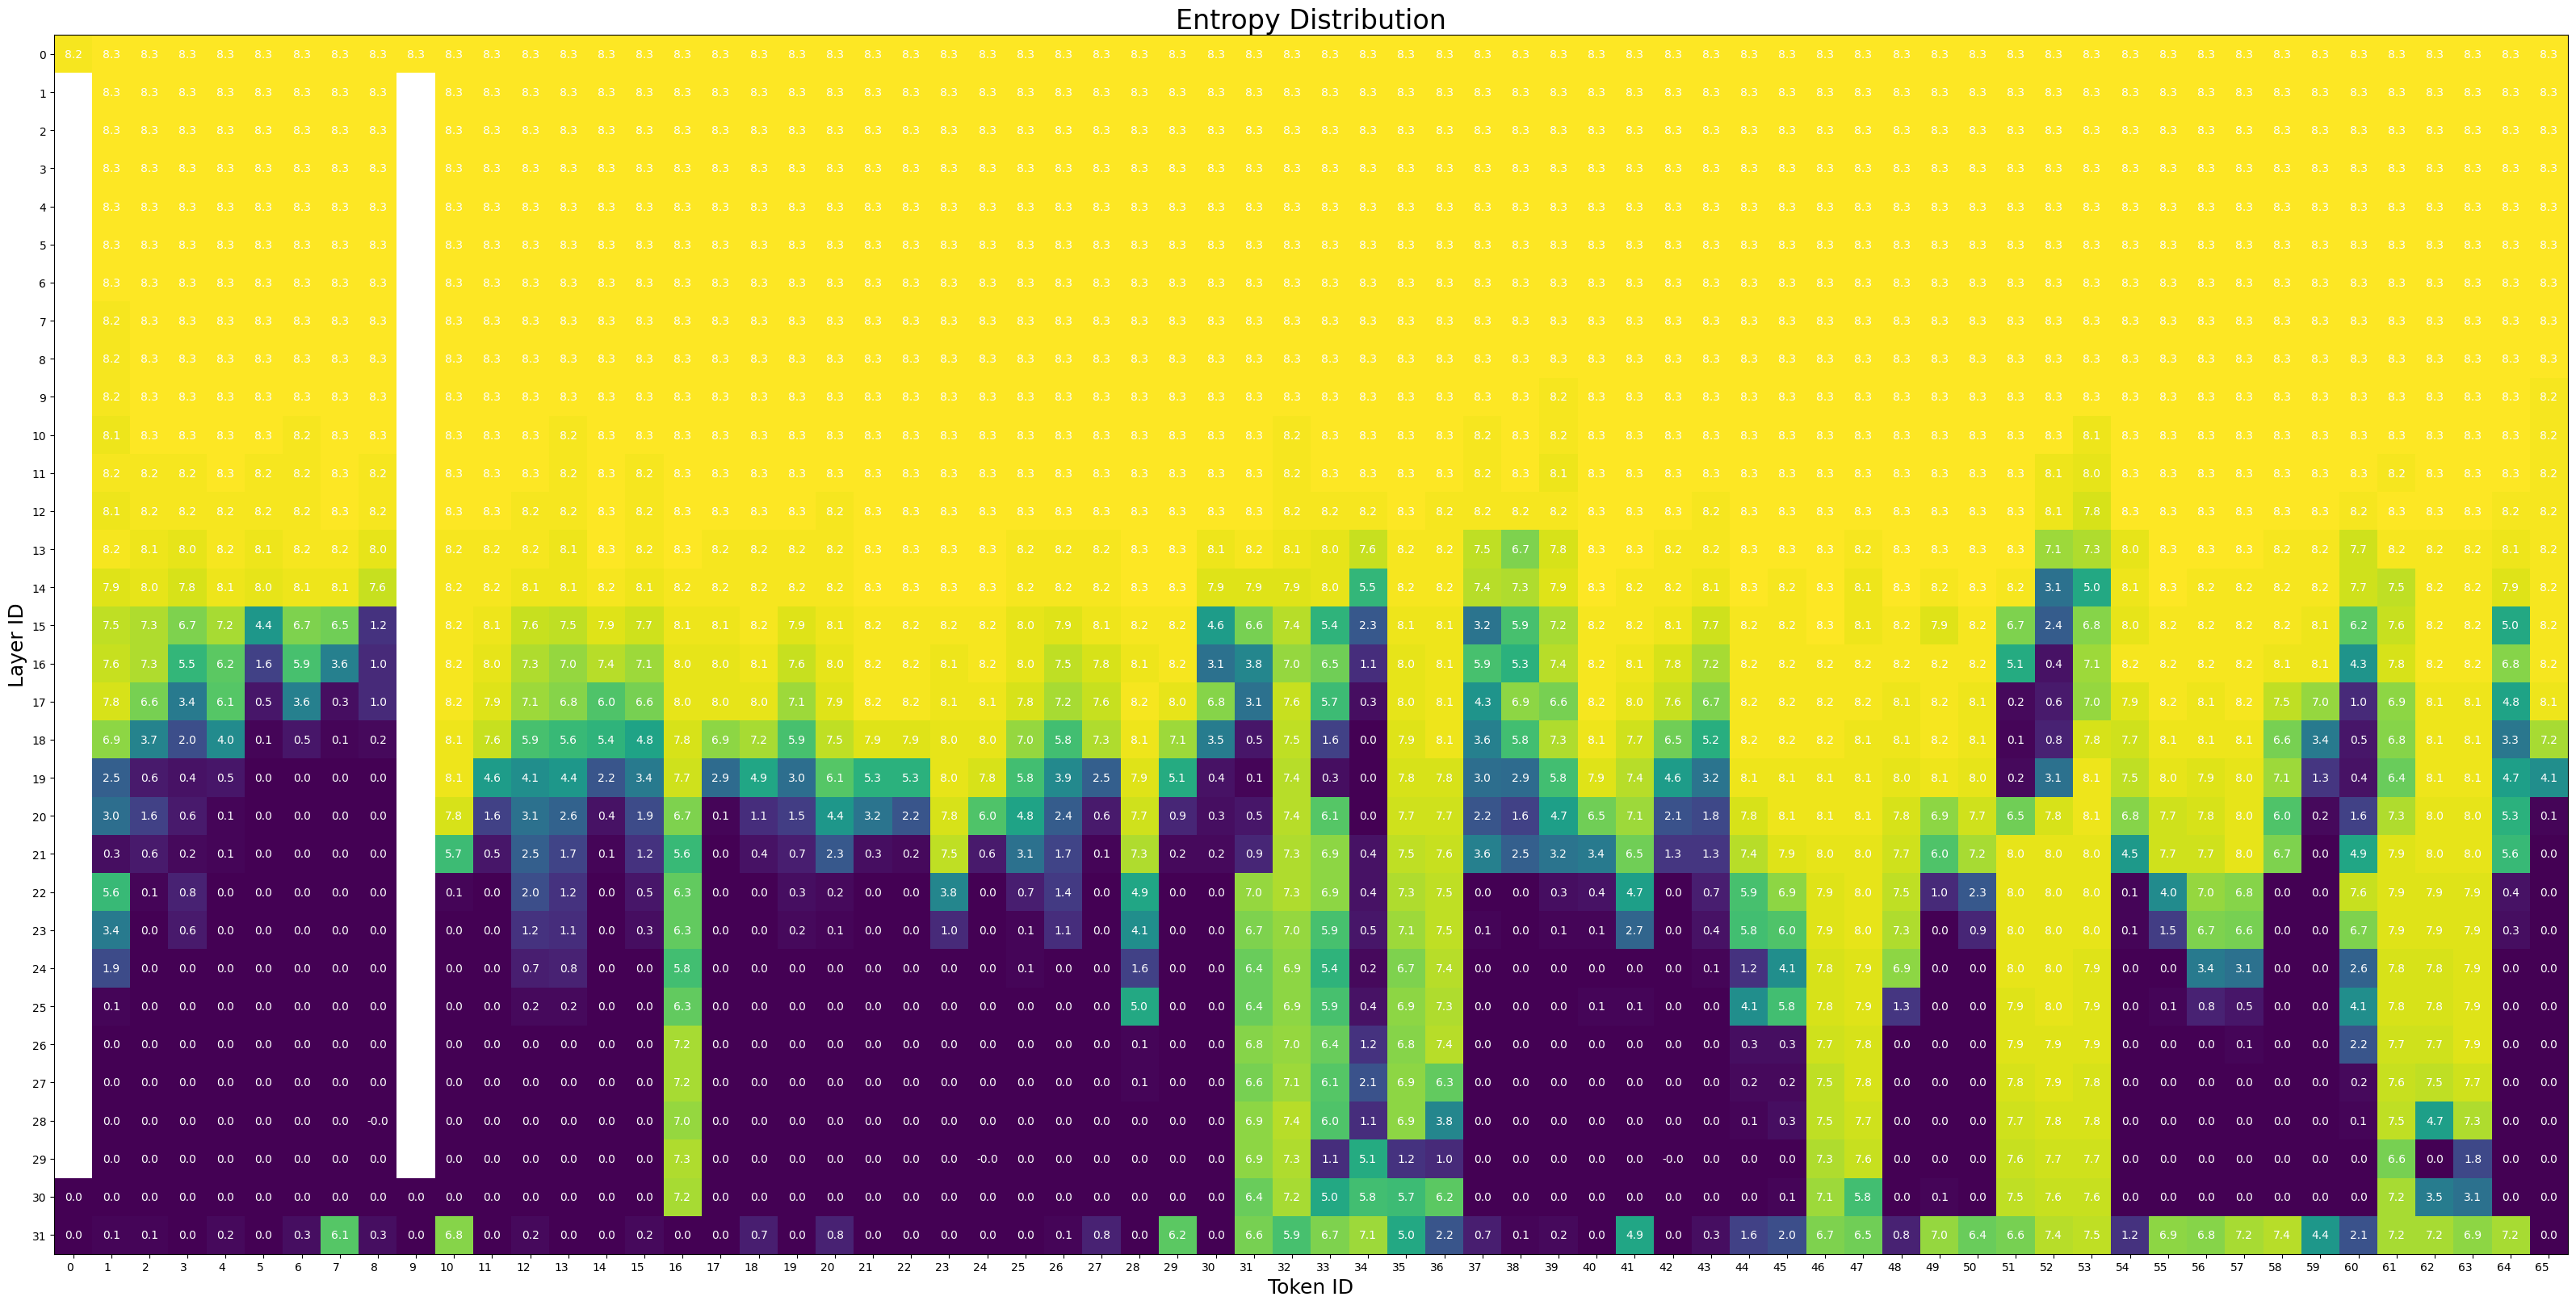

In [8]:
prompt_token_entropy = np.round(prompt_token_entropy, 1)

plt.figure(figsize=(10,6))
fig, ax = plt.subplots(1, figsize=(num_layer, num_token))
im = ax.imshow(prompt_token_entropy)

layers = list(range(num_layer))
tokens = list(range(num_token))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(tokens)), labels=tokens)
ax.set_yticks(np.arange(len(layers)), labels=layers)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in layers:
    for j in tokens:
        text = ax.text(j, i, prompt_token_entropy[i, j],
                       ha="center", va="center", color="w")

ax.set_title('Entropy Distribution', fontsize=24)
plt.xlabel('Token ID', fontsize=18)
plt.ylabel('Layer ID', fontsize=18)

fig.tight_layout()
plt.show()

## Transpose for convex research

In [9]:
# (layers, tokens) tensor -> (tokens, layers) tensor
prompt_token_entropy = prompt_token_entropy.transpose()

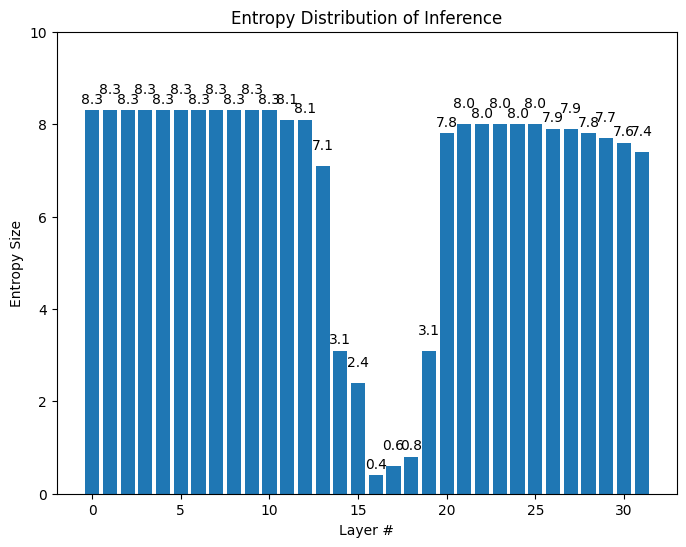

In [10]:
# Sample data
x = range(num_layer)
y = prompt_token_entropy[52]
 
# Create a line chart
plt.figure(figsize=(8, 6))
# plt.plot(x, y, marker='o', linestyle='-')
 
# # Add annotations
# for i, (xi, yi) in enumerate(zip(x, y)):
#   plt.annotate(f'{yi}', (yi), textcoords="offset points", xytext=(0, 10), ha='center')

bars = plt.bar(x, y)

# Loop through the bars and add annotations
i = 0
for bar in bars:
  height = bar.get_height()
  if height == 0:
    continue
  plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height + (i % 2) * 0.2), xytext=(0, 3),
  textcoords="offset points", ha='center', va='bottom')
  i += 1


# Add title and labels
plt.title('Entropy Distribution of Inference')
plt.xlabel('Layer #')
plt.ylabel('Entropy Size')

plt.ylim(0,10)

# Show the plot
plt.show()

## Convex 2-n-2

In [12]:
def convex_identifier_2n2(prompt_token_entropy: np.array, from_layer=2, slope=2):
  convex = False
  convex_start = -1
  convex_end = -1
  num_layer = prompt_token_entropy.shape[-1]

  for layer_idx in range(from_layer, num_layer):
    if convex is False and prompt_token_entropy[layer_idx] > 2:
      continue
    if convex is False and prompt_token_entropy[layer_idx] - prompt_token_entropy[layer_idx - 2] < -slope:
      convex = True
      convex_start = layer_idx - 2
    elif convex is True and prompt_token_entropy[layer_idx] - prompt_token_entropy[layer_idx - 2] > slope:
      convex_end = layer_idx
      break
    # if the convex is continuous until the last layer, this should also be taken as a convex
    elif convex is True and layer_idx == (num_layer - 1):
      convex_end = layer_idx

  if convex_start < 0:
    convex_size = 0
  else:
    convex_size = convex_end - convex_start + 1

  return convex_start, convex_end, convex_size

In [13]:
total_convex = [0 for i in range(num_layer)]
for token_idx in range(num_token):
  yet_fully_searched = True
  from_layer = 2
  while yet_fully_searched:
    convex_start, convex_end, convex_size = convex_identifier_2n2(prompt_token_entropy[token_idx], from_layer=from_layer)
#     print(convex_start, convex_end, convex_size)
    from_layer = convex_end + 1
    if convex_start < 0 or convex_end < 0 :
      yet_fully_searched = False
    else:
      total_convex[max(convex_size - 4, 0)] += 1
      if max(convex_size - 4, 0) > 0:
        print(f"convex token_idx {token_idx}, size {max(convex_size - 4, 0)}, start from {convex_start} to {convex_end}")

convex token_idx 1, size 6, start from 22 to 31
convex token_idx 2, size 11, start from 17 to 31
convex token_idx 3, size 12, start from 16 to 31
convex token_idx 4, size 11, start from 17 to 31
convex token_idx 5, size 14, start from 14 to 31
convex token_idx 6, size 12, start from 16 to 31
convex token_idx 7, size 13, start from 15 to 31
convex token_idx 8, size 15, start from 13 to 31
convex token_idx 10, size 8, start from 20 to 31
convex token_idx 11, size 10, start from 18 to 31
convex token_idx 13, size 9, start from 19 to 31
convex token_idx 14, size 10, start from 18 to 31
convex token_idx 15, size 10, start from 18 to 31
convex token_idx 17, size 10, start from 18 to 31
convex token_idx 18, size 10, start from 18 to 31
convex token_idx 19, size 10, start from 18 to 31
convex token_idx 20, size 8, start from 20 to 31
convex token_idx 21, size 9, start from 19 to 31
convex token_idx 22, size 9, start from 19 to 31
convex token_idx 23, size 7, start from 21 to 31
convex token_id

In [14]:
total_convex[0] = 0
print(f"sum of convex {sum(total_convex)}, number of tokens {num_token}")

sum of convex 58, number of tokens 66


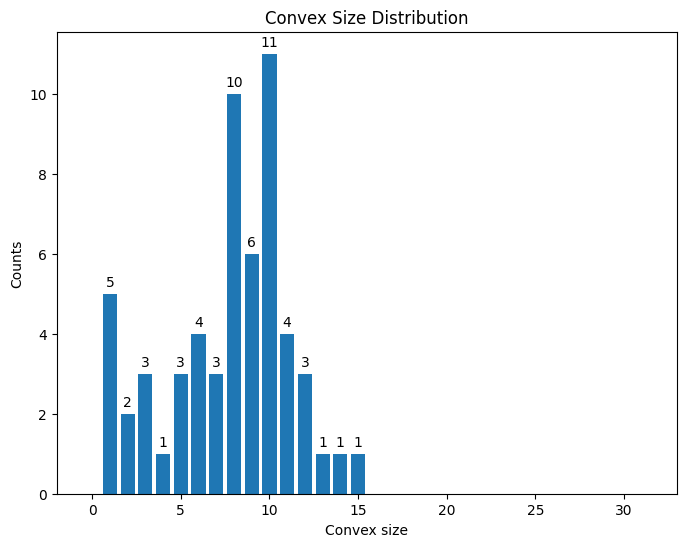

In [15]:
# Sample data
x = range(num_layer)
y = total_convex
 
# Create a line chart
plt.figure(figsize=(8, 6))
# plt.plot(x, y, marker='o', linestyle='-')
 
# # Add annotations
# for i, (xi, yi) in enumerate(zip(x, y)):
#   plt.annotate(f'{yi}', (yi), textcoords="offset points", xytext=(0, 10), ha='center')

bars = plt.bar(x, y)

# Loop through the bars and add annotations
for bar in bars:
  height = bar.get_height()
  if height == 0:
    continue
  plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
  textcoords="offset points", ha='center', va='bottom')


# Add title and labels
plt.title('Convex Size Distribution')
plt.xlabel('Convex size')
plt.ylabel('Counts')
 
# Show the plot
plt.show()

## Convex n reservoir

In [16]:
def convex_identifier_n_res(prompt_token_entropy: np.array, from_layer=0, eps=5e-1, escape_limit=1):
  convex = False
  convex_start = -1
  convex_end = -1
  escape_quota = escape_limit
  num_layer = prompt_token_entropy.shape[-1]

  for layer_idx in range(from_layer, num_layer):
    if convex is False and prompt_token_entropy[layer_idx] < eps:
      convex_start = layer_idx
      convex = True
    elif convex is True and prompt_token_entropy[layer_idx] < eps:
      convex_end = layer_idx
    elif convex is True and prompt_token_entropy[layer_idx] > eps:
      convex_end = layer_idx
      if escape_quota > 0:
        escape_quota -= 1
      else:
        # Not include the element over the eps
        convex_end = layer_idx - 1
        break

    if layer_idx == (num_layer - 1) and convex is True and prompt_token_entropy[layer_idx] > prompt_token_entropy[layer_idx - 1]:
      convex_end = layer_idx

  if convex_start < 0:
    convex_size = 0
  else:
    convex_size = convex_end - convex_start + 1

  return convex_start, convex_end, convex_size

In [17]:
total_convex = [0 for i in range(num_layer)]
for token_idx in range(num_token):
  yet_fully_searched = True
  from_layer = 0
  while yet_fully_searched:
    convex_start, convex_end, convex_size = convex_identifier_n_res(prompt_token_entropy[token_idx], from_layer=from_layer)
    from_layer = convex_end + 1
    if convex_start < 0 or convex_end < 0 :
      yet_fully_searched = False
    else:
      total_convex[convex_size] += 1
    if convex_size > 0:
      print(f"convex token_idx {token_idx}, size {convex_size}, start from {convex_start} to {convex_end}")

convex token_idx 0, size 2, start from 30 to 31
convex token_idx 1, size 2, start from 21 to 22
convex token_idx 1, size 7, start from 25 to 31
convex token_idx 2, size 10, start from 22 to 31
convex token_idx 3, size 3, start from 19 to 21
convex token_idx 3, size 8, start from 24 to 31
convex token_idx 4, size 12, start from 20 to 31
convex token_idx 5, size 14, start from 18 to 31
convex token_idx 6, size 13, start from 19 to 31
convex token_idx 7, size 15, start from 17 to 31
convex token_idx 8, size 14, start from 18 to 31
convex token_idx 9, size 2, start from 30 to 31
convex token_idx 10, size 10, start from 22 to 31
convex token_idx 11, size 10, start from 22 to 31
convex token_idx 12, size 7, start from 25 to 31
convex token_idx 13, size 7, start from 25 to 31
convex token_idx 14, size 12, start from 20 to 31
convex token_idx 15, size 9, start from 23 to 31
convex token_idx 17, size 12, start from 20 to 31
convex token_idx 18, size 11, start from 21 to 31
convex token_idx 19, 

In [18]:
total_convex[0] = 0
print(f"sum of convex {sum(total_convex)}, number of tokens {num_token}")

sum of convex 60, number of tokens 66


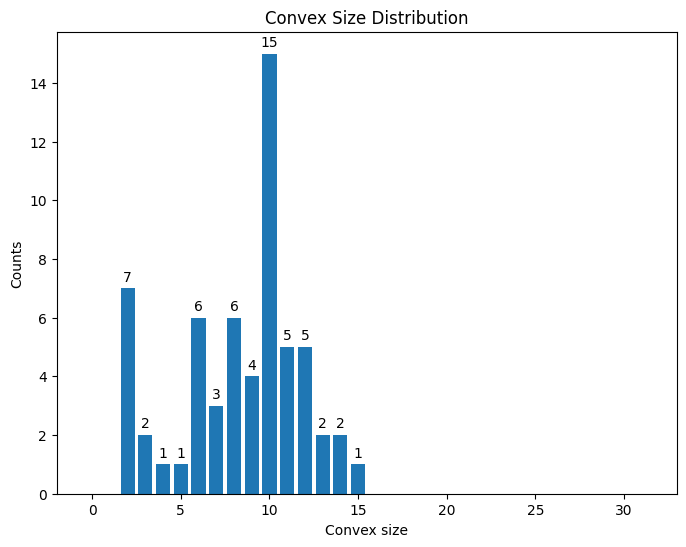

In [19]:
# Sample data
x = range(num_layer)
y = total_convex
 
# Create a line chart
plt.figure(figsize=(8, 6))
# plt.plot(x, y, marker='o', linestyle='-')
 
# # Add annotations
# for i, (xi, yi) in enumerate(zip(x, y)):
#   plt.annotate(f'{yi}', (yi), textcoords="offset points", xytext=(0, 10), ha='center')

bars = plt.bar(x, y)

# Loop through the bars and add annotations
for bar in bars:
  height = bar.get_height()
  if height == 0:
    continue
  plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
  textcoords="offset points", ha='center', va='bottom')


# Add title and labels
plt.title('Convex Size Distribution')
plt.xlabel('Convex size')
plt.ylabel('Counts')
 
# Show the plot
plt.show()

# Calculate total convex

In [20]:
def load_convex(entropy_save_prefix, entropy_save_dir, q_range, not_include_prompt=False):
  # entropy_save_prefix: the prefix of all saved entropy dump
  # entropy_save_dir: the directory of saved entropy
  # q_range: the range of q_id [0, q_range]
  # not_include_prompt: whether or not to include prompt into the result
  # because the original layout is in (layer, token)
  total_prompt_token_entropy = []
  total_num_prompt_token = 0
  total_num_token = 0

  for q_id in range(q_range + 1):
    num_prompt_token, num_token, prompt_token_entropy = retrieve_prompt_token_entropy(os.path.join(entropy_save_dir, f'q_{q_id}'), entropy_save_prefix, num_layer, not_include_prompt=not_include_prompt)
    total_prompt_token_entropy.append(prompt_token_entropy.numpy().transpose())
    total_num_prompt_token += num_prompt_token
    total_num_token += num_token

  return total_num_prompt_token, total_num_token, total_prompt_token_entropy

# Including the prompt

In [21]:
entropy_save_prefix = 'entropy'
entropy_save_dir = f'{home_dir}/entropy_research/dumps'
total_num_prompt_token, total_num_token, total_prompt_token_entropy = load_convex(entropy_save_prefix, entropy_save_dir, 1000)

## Entropy Mean Distribution

In [42]:
mean = np.array([0 for i in range(32)], dtype=np.float64)

In [45]:
for i in range(len(total_prompt_token_entropy)):
  mean += np.nanmean(total_prompt_token_entropy[i], axis=0)

In [46]:
print(mean)

[8323.79419484 8325.07465988 8324.35709466 8322.65060193 8320.20414285
 8317.40967119 8313.30104412 8307.30279711 8299.81887944 8281.86745515
 8267.5070304  8252.37961876 8221.26851475 8018.85338504 7895.51284414
 7341.52319093 6981.7380797  6592.18987645 5900.75035379 5001.81114456
 4457.88694318 3816.71619898 2954.44693865 2554.59181308 2040.82734593
 1929.59132508 1627.6499379  1447.38485626 1286.5341755  1130.21929901
 1122.47262176 3740.0336287 ]


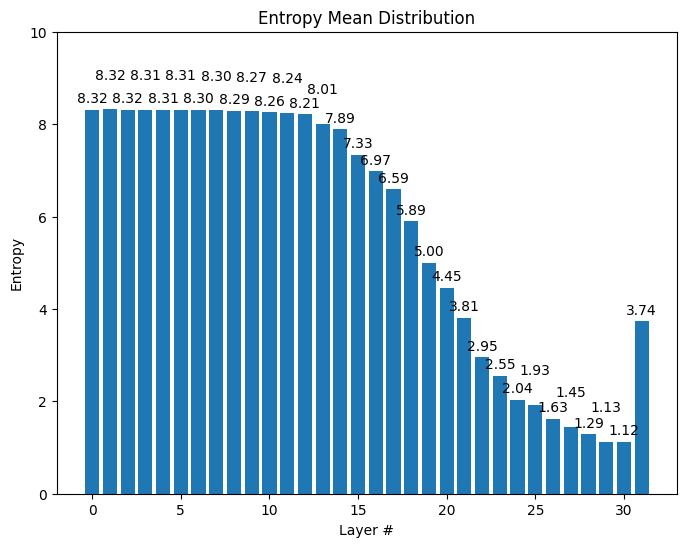

In [73]:
# Sample data
x = range(num_layer)
y = mean / 1001.0
 
# Create a line chart
plt.figure(figsize=(8, 6))
# plt.plot(x, y, marker='o', linestyle='-')
 
# # Add annotations
# for i, (xi, yi) in enumerate(zip(x, y)):
#   plt.annotate(f'{yi}', (yi), textcoords="offset points", xytext=(0, 10), ha='center')

bars = plt.bar(x, y)

# Loop through the bars and add annotations
i = 0
last_height = 0
for bar in bars:
  height = bar.get_height()
  if height == 0:
    continue
  
  print_height = height
  if abs(height - last_height) < 0.3:
    print_height += (i % 2) * 0.5

  plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, print_height), xytext=(0, 3),
  textcoords="offset points", ha='center', va='bottom')
  i += 1
  last_height = height

# Add title and labels
plt.title('Entropy Mean Distribution')
plt.xlabel('Layer #')
plt.ylabel('Entropy')

plt.ylim(0,10)

# Show the plot
plt.show()

## Convex

In [22]:
def examine_convex_2n2(total_prompt_token_entropy: list, slope=2.0):
  total_convex = [0 for i in range(num_layer)]
  total_convex_start = [0 for i in range(num_layer)]

  for q_id in range(len(total_prompt_token_entropy)):
    num_token = total_prompt_token_entropy[q_id].shape[0]
    for token_idx in range(num_token):
      yet_fully_searched = True
      from_layer = 2
      while yet_fully_searched:
        convex_start, convex_end, convex_size = convex_identifier_2n2(total_prompt_token_entropy[q_id][token_idx], from_layer=from_layer, slope=slope)
        from_layer = convex_end + 1
        if convex_start < 0 or convex_end < 0 :
          yet_fully_searched = False
        else:
          if convex_end > 29:
            convex_size = max(convex_size - (num_layer - 28), 0)
          else:
            convex_size = max(convex_size - 3, 0)
          total_convex[convex_size] += 1
          if convex_size != 0 and convex_start < 25:
            total_convex_start[convex_start + 2] += 1

  total_convex[0] = 0

  return total_convex, total_convex_start

In [23]:
total_convex, total_convex_start = examine_convex_2n2(total_prompt_token_entropy, slope=2)
print(f"sum of convex {sum(total_convex)}, number of tokens {total_num_token}")

sum of convex 117394, number of tokens 133663


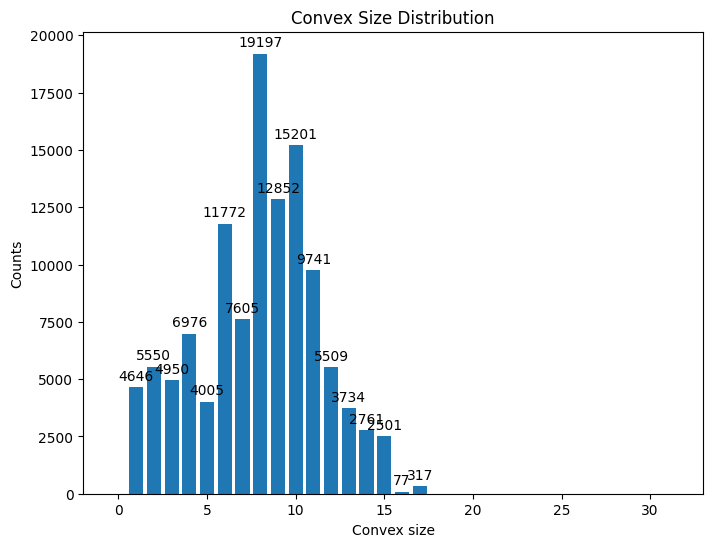

In [24]:
# Sample data
x = range(num_layer)
y = total_convex
 
# Create a line chart
plt.figure(figsize=(8, 6))
# plt.plot(x, y, marker='o', linestyle='-')
 
# # Add annotations
# for i, (xi, yi) in enumerate(zip(x, y)):
#   plt.annotate(f'{yi}', (yi), textcoords="offset points", xytext=(0, 10), ha='center')

bars = plt.bar(x, y)

# Loop through the bars and add annotations
for bar in bars:
  height = bar.get_height()
  if height == 0:
    continue
  plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
  textcoords="offset points", ha='center', va='bottom')


# Add title and labels
plt.title('Convex Size Distribution')
plt.xlabel('Convex size')
plt.ylabel('Counts')
 
# Show the plot
plt.show()

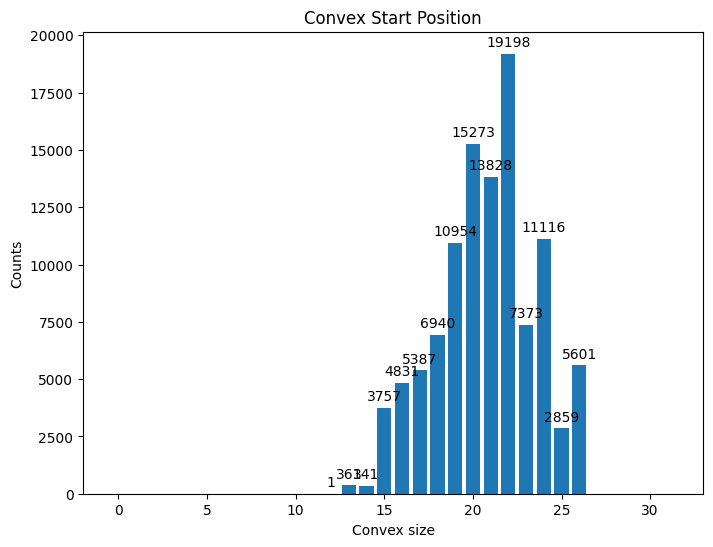

In [25]:
# Sample data
x = range(num_layer)
y = total_convex_start
 
# Create a line chart
plt.figure(figsize=(8, 6))
# plt.plot(x, y, marker='o', linestyle='-')
 
# # Add annotations
# for i, (xi, yi) in enumerate(zip(x, y)):
#   plt.annotate(f'{yi}', (yi), textcoords="offset points", xytext=(0, 10), ha='center')

bars = plt.bar(x, y)

# Loop through the bars and add annotations
for bar in bars:
  height = bar.get_height()
  if height == 0:
    continue
  plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
  textcoords="offset points", ha='center', va='bottom')


# Add title and labels
plt.title('Convex Start Position')
plt.xlabel('Convex size')
plt.ylabel('Counts')
 
# Show the plot
plt.show()

In [108]:
print(f"Area of convex to number of tokens {sum([i * total_convex[i] for i in range(len(total_convex))]) / (total_num_token * num_layer)} %")

Area of convex to number of tokens 0.22134819106623835 %


In [124]:
def examine_convex_n_res(total_prompt_token_entropy: list):
  total_tokens = 0
  total_convex = [0 for i in range(num_layer)]

  for q_id in range(len(total_prompt_token_entropy)):
    num_token = total_prompt_token_entropy[q_id].shape[0]
    for token_idx in range(num_token):
      yet_fully_searched = True
      from_layer = 0
      while yet_fully_searched:
        convex_start, convex_end, convex_size = convex_identifier_n_res(total_prompt_token_entropy[q_id][token_idx], from_layer=from_layer, eps=1.2, escape_limit=1)
        from_layer = convex_end + 1
        if convex_start < 0 or convex_end < 0 :
          yet_fully_searched = False
        else:
          if(convex_end > 29):
            convex_size = max(convex_size - (num_layer - 28), 0)
          total_convex[convex_size] += 1
#         if convex_size > 0:
#           print(f"convex token_idx {token_idx}, size {convex_size}, start from {convex_start} to {convex_end}")

  total_convex[0] = 0

  return total_convex

In [125]:
total_convex = examine_convex_n_res(total_prompt_token_entropy)
print(f"sum of convex {sum(total_convex)}, number of tokens {total_num_token}")

sum of convex 11063, number of tokens 13074


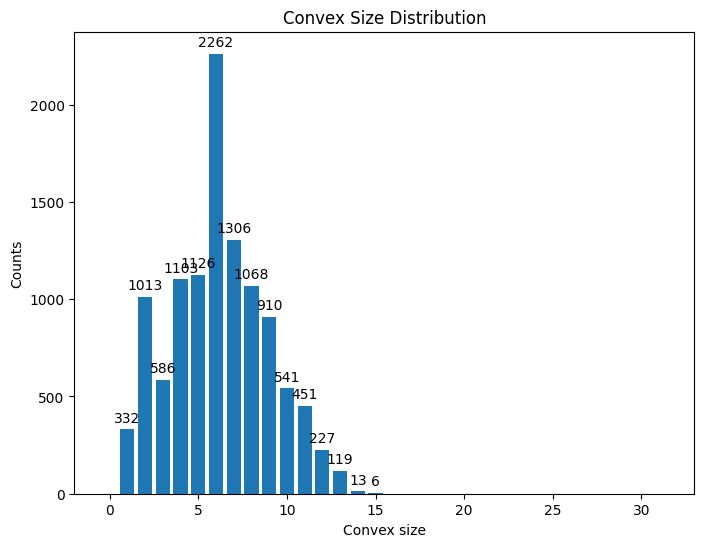

In [126]:
# Sample data
x = range(num_layer)
y = total_convex
 
# Create a line chart
plt.figure(figsize=(8, 6))
# plt.plot(x, y, marker='o', linestyle='-')
 
# # Add annotations
# for i, (xi, yi) in enumerate(zip(x, y)):
#   plt.annotate(f'{yi}', (yi), textcoords="offset points", xytext=(0, 10), ha='center')

bars = plt.bar(x, y)

# Loop through the bars and add annotations
for bar in bars:
  height = bar.get_height()
  if height == 0:
    continue
  plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
  textcoords="offset points", ha='center', va='bottom')


# Add title and labels
plt.title('Convex Size Distribution')
plt.xlabel('Convex size')
plt.ylabel('Counts')
 
# Show the plot
plt.show()

In [127]:
print(f"Area of convex to number of tokens {sum([i * total_convex[i] for i in range(len(total_convex))]) / (total_num_token * num_layer)} %")

Area of convex to number of tokens 0.1637792565396971 %


# Not including the prompt

In [43]:
entropy_save_prefix = 'entropy'
entropy_save_dir = f'{home_dir}/entropy_research/dumps'
total_num_prompt_token, total_num_token, total_prompt_token_entropy = load_convex(entropy_save_prefix, entropy_save_dir, 100, not_include_prompt=True)

In [44]:
def examine_convex(total_prompt_token_entropy: list, slope=2.0):
  total_tokens = 0
  total_convex = [0 for i in range(num_layer)]

  for q_id in range(len(total_prompt_token_entropy)):
    num_token = total_prompt_token_entropy[q_id].shape[0]
    for token_idx in range(num_token):
      convex_start, convex_end, convex_size = convex_identifier(total_prompt_token_entropy[q_id][token_idx])
      total_convex[max(convex_size - 4, 0)] += 1
#       if max(convex_size - 4, 0) > 0:
#         print(f"convex token_idx {token_idx}, size {convex_size - 4}, start from {convex_start} to {convex_end}")

  total_convex[0] = 0

  return total_convex

In [45]:
total_convex = examine_convex(total_prompt_token_entropy, slope=2.0)
print(f"sum of convex {sum(total_convex)}, number of tokens {total_num_token}")

sum of convex 7282, number of tokens 8139


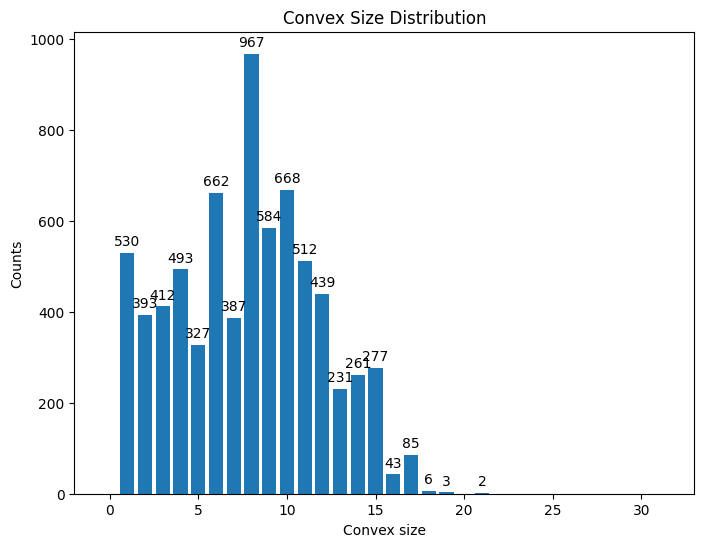

In [46]:
# Sample data
x = range(num_layer)
y = total_convex
 
# Create a line chart
plt.figure(figsize=(8, 6))
# plt.plot(x, y, marker='o', linestyle='-')
 
# # Add annotations
# for i, (xi, yi) in enumerate(zip(x, y)):
#   plt.annotate(f'{yi}', (yi), textcoords="offset points", xytext=(0, 10), ha='center')

bars = plt.bar(x, y)

# Loop through the bars and add annotations
for bar in bars:
  height = bar.get_height()
  if height == 0:
    continue
  plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
  textcoords="offset points", ha='center', va='bottom')


# Add title and labels
plt.title('Convex Size Distribution')
plt.xlabel('Convex size')
plt.ylabel('Counts')
 
# Show the plot
plt.show()

In [47]:
print(f"Area of convex to number of tokens {sum([i * total_convex[i] for i in range(len(total_convex))]) / (total_num_token * num_layer)} %")

Area of convex to number of tokens 0.2171796289470451 %
